In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.physics import ert
import pygimli.physics.traveltime as tt
import os
import sys
import matplotlib.pylab as pylab
params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 14,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"


# For Jupyter notebooks, use the current working directory
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()
# Add the parent directory (OPEN_ERT) to the path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)


# Import the time-lapse inversion class
from watershed_geophysics.inversion.time_lapse import TimeLapseERTInversion

In [ ]:
Geophy_modular = 0

In [ ]:
Geophy_modular.seismic_processor
Geophy_modular.structure_integration

In [2]:
output_dir = "results/Structure_WC"
os.makedirs(output_dir, exist_ok=True)

In [3]:
## load seismic data
ttData = tt.load("./results/workflow_example/synthetic_seismic_data.dat")
## load ERT data
ertData = ert.load("./results/TL_measurements/appres/synthetic_data30.dat")

In [4]:
paraBoundary = 0.1

10/05/25 - 12:02:09 - pyGIMLi - INFO - Found 2 regions.
10/05/25 - 12:02:09 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Found 2 regions.
10/05/25 - 12:02:09 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5661 Cells: 10936 Boundaries: 8394


(<Axes: >, None)

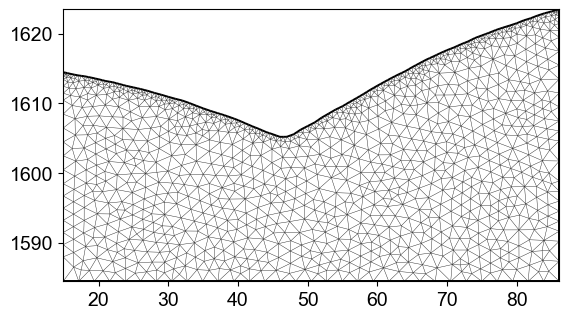

In [5]:
## using ERT data to create a mesh to take care of the boundary

ert1 = ert.ERTManager(ertData)
grid = ert1.createMesh(data=ertData,quality = 31,paraDX=0.5, paraMaxCellSize=2, boundaryMaxCellSize=3000,smooth=[2, 2],
                       paraBoundary = paraBoundary, paraDepth = 30.0)
ert1.setMesh(grid)
mesh = ert1.fop.paraDomain
mesh.setCellMarkers(np.ones((mesh.cellCount()))*2)
pg.show(mesh)

In [6]:
## travel time inversion

TT = pg.physics.traveltime.TravelTimeManager()
TT.setMesh(mesh)
TT.invert(ttData, lam=50,
          zWeight=0.2,vTop=500, vBottom=5000,
          verbose=1, limits=[100., 6000.])



10/05/25 - 12:02:09 - pyGIMLi - INFO - Found 1 regions.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
10/05/25 - 12:02:09 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
10/05/25 - 12:02:09 - pyGIMLi - INFO - Created startmodel from forward operator: 2119, min/max=0.000200/0.002000
10/05/25 - 12:02:09 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x0000027A1C81AFC0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000027A1C819A80>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000027A0FDEAE30>
min/max (data): 0.0014/0.06
min/max (error): 4.35%/6.41%
min/max (start model): 2.0e-04/0.002
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   39.26
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    1.71 (dPhi = 95.15%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.96 (dPhi = 39.94%) lam: 50.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.96)                   #
################################################################################


2119 [521.1059498801347,...,3025.020493529727]

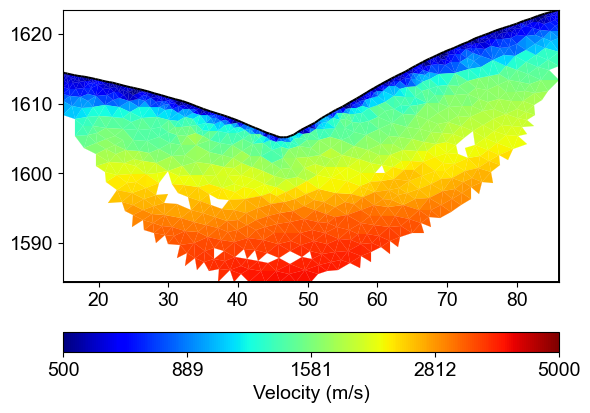

In [7]:
ax, cbar = TT.showResult(cMap='jet',coverage=TT.standardizedCoverage(),cMin=500,cMax=5000)

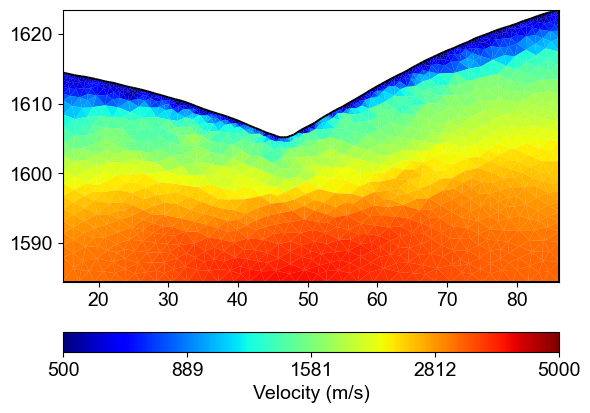

In [8]:
ax, cbar = TT.showResult(cMap='jet',cMin=500,cMax=5000)

Mesh: Nodes: 1172 Cells: 2119 Boundaries: 223
[ 521.10594988  715.39654339  664.83582813 ... 3667.09361155 3714.2930351
 3025.02049353]


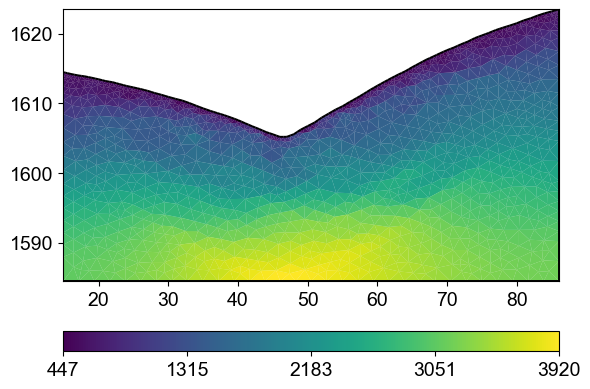

In [9]:
pg.show(TT.paraDomain,TT.model.array())
print(TT.paraDomain)
print(TT.model.array())

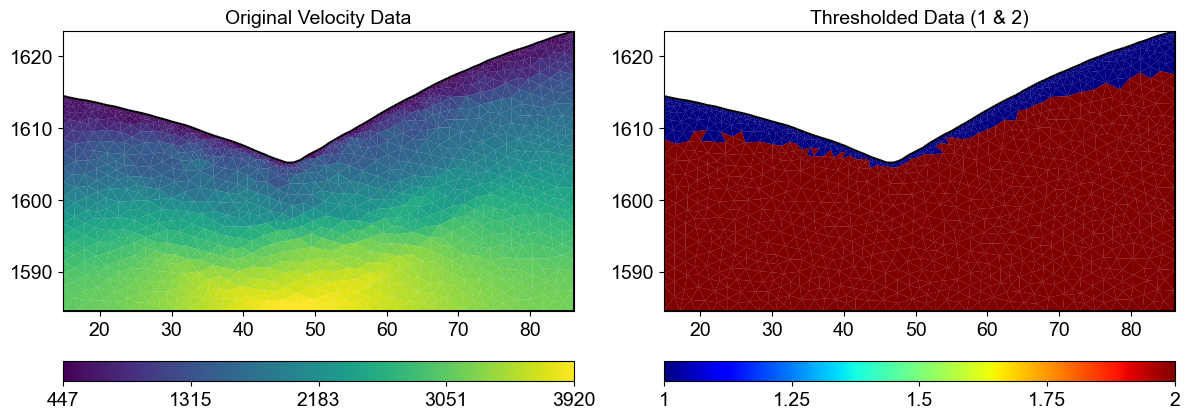

In [10]:
import numpy as np

# Assuming TT.model.array() gives you the velocity values
velocity_data = TT.model.array()

# Get the mesh shape
mesh = TT.paraDomain
cell_centers = mesh.cellCenters()
x_coords = cell_centers[:,0]  # X-coordinates of cell centers
z_coords = cell_centers[:,1]  # Z-coordinates (depth) of cell centers

# Create a new array for the thresholded values
thresholded = np.ones_like(velocity_data, dtype=int)

# Get unique x-coordinates (horizontal distances)
unique_x = np.unique(x_coords)

# For each vertical column (each unique x-coordinate)
for x in unique_x:
    # Get indices of cells in this column, sorted by depth (z-coordinate)
    column_indices = np.where(x_coords == x)[0]
    column_indices = column_indices[np.argsort(z_coords[column_indices])]
    
    # Check if any cell in this column exceeds the threshold
    threshold_crossed = False
    
    # Process cells from top to bottom
    for idx in column_indices:
        if velocity_data[idx] >= 1200 or threshold_crossed:
            thresholded[idx] = 2
            threshold_crossed = True
        # Otherwise thresholded[idx] remains 1

# Now thresholded contains your classified values (1 or 2)
# Let's visualize the result
import matplotlib.pyplot as plt

# Create a figure with two subplots to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original data
pg.show(mesh, velocity_data, ax=ax1, cMap='viridis', colorBar=True)
ax1.set_title('Original Velocity Data')

# Thresholded data
pg.show(mesh, thresholded, ax=ax2, cMap='jet', colorBar=True)
ax2.set_title('Thresholded Data (1 & 2)')

plt.tight_layout()
plt.show()

In [11]:
from scipy.interpolate import interp1d

def extract_velocity_interface(mesh, velocity_data, threshold=1200,interval = 4.0 ):
    """
    Extract the interface where velocity equals the threshold value.
    
    Parameters:
    mesh - The PyGIMLi mesh
    velocity_data - The velocity values
    threshold - The velocity value defining the interface (default: 1200)
    
    Returns:
    x_dense, z_dense - Arrays with x and z coordinates of the smooth interface
    """
    # Get cell centers
    cell_centers = mesh.cellCenters()
    x_coords = cell_centers[:,0]
    z_coords = cell_centers[:,1]
    
    # Get x-range for complete boundary
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    
    # Create bins across the entire x-range
     # Adjust for desired precision
    x_bins = np.arange(x_min, x_max + interval, interval)
    
    # Arrays to store interface points
    interface_x = []
    interface_z = []
    
    # For each bin, find the velocity interface
    for i in range(len(x_bins)-1):
        # Get all cells in this x-range
        bin_indices = np.where((x_coords >= x_bins[i]) & (x_coords < x_bins[i+1]))[0]
        
        if len(bin_indices) > 0:
            # Get velocity values and depths for this bin
            bin_velocities = velocity_data[bin_indices]
            bin_depths = z_coords[bin_indices]
            
            # Sort by depth
            sort_indices = np.argsort(bin_depths)
            bin_velocities = bin_velocities[sort_indices]
            bin_depths = bin_depths[sort_indices]
            
            # Find where velocity crosses the threshold
            for j in range(1, len(bin_velocities)):
                if (bin_velocities[j-1] < threshold and bin_velocities[j] >= threshold) or \
                   (bin_velocities[j-1] >= threshold and bin_velocities[j] < threshold):
                    # Linear interpolation for exact interface depth
                    v1 = bin_velocities[j-1]
                    v2 = bin_velocities[j]
                    z1 = bin_depths[j-1]
                    z2 = bin_depths[j]
                    
                    # Calculate the interpolated z-value where velocity = threshold
                    ratio = (threshold - v1) / (v2 - v1)
                    interface_depth = z1 + ratio * (z2 - z1)
                    
                    interface_x.append((x_bins[i] + x_bins[i+1]) / 2)
                    interface_z.append(interface_depth)
                    break
    
    # Ensure we have interface points for the entire range
    # If first point is missing, extrapolate from the first available points
    if len(interface_x) > 0 and interface_x[0] > x_min + interval:
        interface_x.insert(0, x_min)
        # Use the slope of the first two points to extrapolate
        if len(interface_x) > 2:
            slope = (interface_z[1] - interface_z[0]) / (interface_x[1] - interface_x[0])
            interface_z.insert(0, interface_z[0] - slope * (interface_x[1] - x_min))
        else:
            interface_z.insert(0, interface_z[0])
    
    # If last point is missing, extrapolate from the last available points
    if len(interface_x) > 0 and interface_x[-1] < x_max - interval:
        interface_x.append(x_max)
        # Use the slope of the last two points to extrapolate
        if len(interface_x) > 2:
            slope = (interface_z[-1] - interface_z[-2]) / (interface_x[-1] - interface_x[-2])
            interface_z.append(interface_z[-1] + slope * (x_max - interface_x[-1]))
        else:
            interface_z.append(interface_z[-1])
    
    # Create a dense interpolation grid for smoothing
    x_dense = np.linspace(x_min, x_max, 500)  # 500 points for smooth curve
    
    # Apply cubic interpolation for smoother interface
    if len(interface_x) > 3:
        try:
            interp_func = interp1d(interface_x, interface_z, kind='cubic', 
                                bounds_error=False, fill_value="extrapolate")
            z_dense = interp_func(x_dense)
            
            # Apply additional smoothing
            from scipy.signal import savgol_filter
            z_dense = savgol_filter(z_dense, window_length=31, polyorder=3)
        except:
            # Fall back to linear interpolation if cubic fails
            interp_func = interp1d(interface_x, interface_z, kind='linear',
                                bounds_error=False, fill_value="extrapolate")
            z_dense = interp_func(x_dense)
    else:
        # Not enough points for cubic interpolation
        interp_func = interp1d(interface_x, interface_z, kind='linear',
                               bounds_error=False, fill_value="extrapolate")
        z_dense = interp_func(x_dense)
    


    
    return x_dense, z_dense


In [12]:

# Call the function with velocity data
smooth_x, smooth_z = extract_velocity_interface(mesh, velocity_data, threshold=1200,interval = 5)

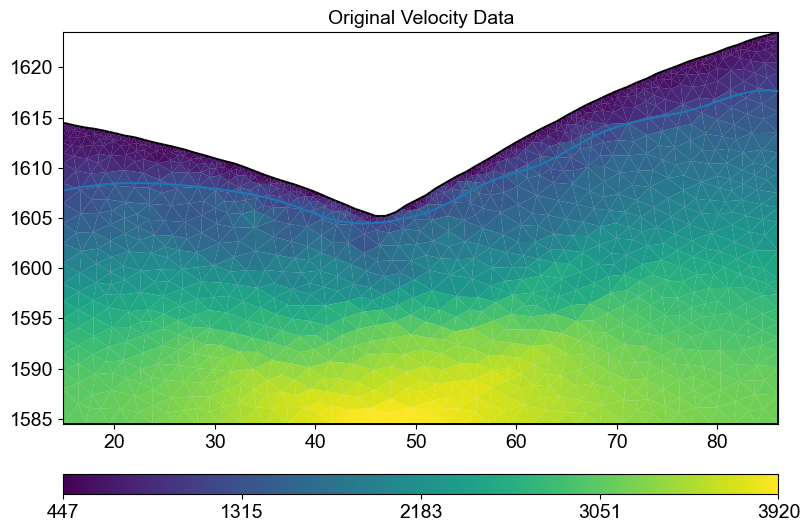

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Original data
pg.show(mesh, velocity_data, ax=ax1, cMap='viridis', colorBar=True)
ax1.set_title('Original Velocity Data')
ax1.plot(smooth_x, smooth_z)

(<Axes: >, None)

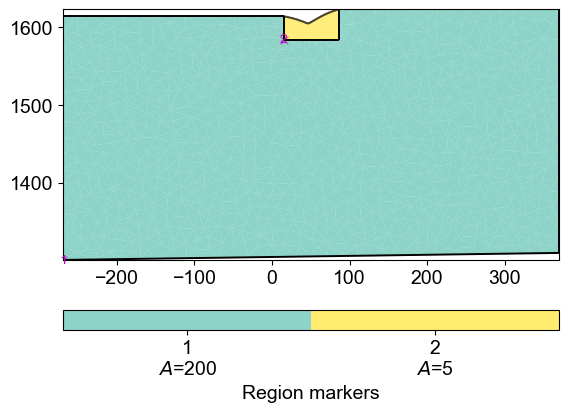

In [14]:
geo = pg.meshtools.createParaMeshPLC(ertData, quality=31, paraMaxCellSize=5,
                                        paraBoundary=paraBoundary,paraDepth = 30.0,boundaryMaxCellSize=200)

pg.show(geo)


In [15]:
def add_velocity_interface(ertData, smooth_x, smooth_z, paraBoundary=2, boundary=1):
    """
    Add a velocity interface line to the geometry and create a mesh with different markers:
    - Outside survey area: marker = 1
    - Inside survey area, above velocity line: marker = 2
    - Inside survey area, below velocity line: marker = 3
    
    Parameters:
    ertData - ERT data with sensor positions
    smooth_x, smooth_z - Arrays with x and z coordinates of the velocity interface
    paraBoundary, boundary - Mesh parameters
    
    Returns:
    markers - Array with cell markers
    meshafter - The created mesh with updated markers
    """
    # Create the initial parameter mesh
    geo = pg.meshtools.createParaMeshPLC(ertData, quality=32, paraMaxCellSize=30,
                                         paraBoundary=paraBoundary, paraDepth=30.0,
                                         boundaryMaxCellSize=500)
    
    # Stack x and z coordinates for the interface
    interface_points = np.vstack((smooth_x, smooth_z)).T
    
    # Extend the interface line beyond the data range by paraBoundary
    input_points = np.vstack((
        np.array([[interface_points[0][0] - paraBoundary, interface_points[0][1]]]),
        interface_points,
        np.array([[interface_points[-1][0] + paraBoundary, interface_points[-1][1]]])
    ))
    
    # Create a polygon line for the interface
    interface_line = pg.meshtools.createPolygon(input_points.tolist(), isClosed=False,
                                              interpolate='linear', marker=99)
    
    # Add the interface to the geometry
    geo_with_interface = geo + interface_line
    
    # Create a mesh from the combined geometry
    meshafter = pg.meshtools.createMesh(geo_with_interface, quality=28)
    
    # Initialize all markers to 1 (outside region)
    markers = np.ones(meshafter.cellCount())
    
    # Identify the survey area
    survey_left = ertData.sensors()[0][0] - paraBoundary
    survey_right = ertData.sensors()[-1][0] + paraBoundary
    
    # Process each cell
    for i in range(meshafter.cellCount()):
        cell_x = meshafter.cell(i).center().x()
        cell_y = meshafter.cell(i).center().y()
        
        # Only modify markers within the survey area
        if cell_x >= survey_left and cell_x <= survey_right:
            # Interpolate the interface height at this x position
            interface_y = np.interp(cell_x, input_points[:, 0], input_points[:, 1])
            
            # Set marker based on position relative to interface
            if abs(cell_y) < abs(interface_y):
                markers[i] = 2  # Below interface
            else:
                markers[i] = 3  # Above interface
    
    markers[meshafter.cellMarkers()==1] = 1 # Keep original markers for outside cells`
    # Set the updated markers
    meshafter.setCellMarkers(markers)
    
    return markers, meshafter

# Example usage:
# markers, meshafter = add_velocity_interface(ertData, smooth_x, smooth_z)
# pg.show(meshafter, markers=True, label='Region markers')

In [16]:
markers, mesh_with_interface = add_velocity_interface(ertData, smooth_x, smooth_z)
mesh_with_interface

Mesh: Nodes: 2804 Cells: 5393 Boundaries: 8196

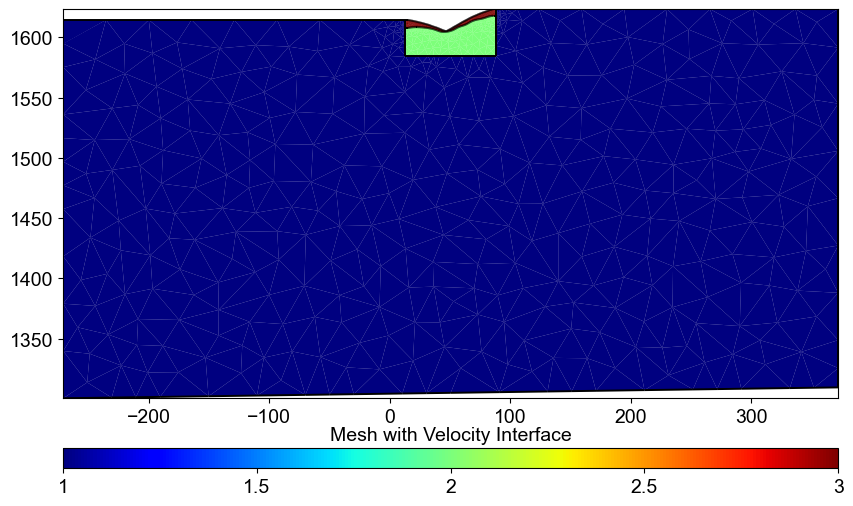

In [17]:

fig, ax = plt.subplots(figsize=(10, 6))
pg.show(mesh_with_interface, markers, ax=ax, cMap='jet', colorBar=True)
plt.title('Mesh with Velocity Interface')
plt.show()

(1580.0, 1630.0)

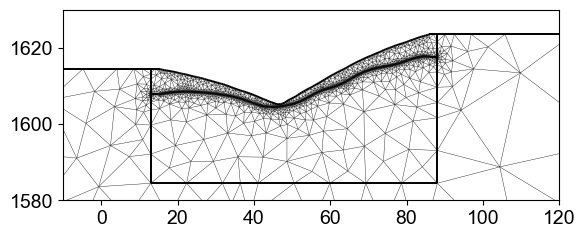

In [18]:
ax, cbar = pg.show(mesh_with_interface)
ax.set_xlim([-10,120])
ax.set_ylim([1580,1630])

In [19]:
mesh_with_interface

Mesh: Nodes: 2804 Cells: 5393 Boundaries: 8196

In [20]:
mgrConstrained = ert.ERTManager()
mgrConstrained.invert(data=ertData, verbose=True, lam=10, mesh=mesh_with_interface,limits=[1., 10000.])

10/05/25 - 12:02:20 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:02:20 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:02:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:02:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/05/25 - 12:02:20 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 11000 Cells: 21572 Boundaries: 16392
10/05/25 - 12:02:20 - pyGIMLi - INFO - Use median(data values)=1403.18379417477
10/05/25 - 12:02:20 - pyGIMLi - INFO - Created startmodel from forward operator: 4501, min/max=1403.183794/1403.183794
10/05/25 - 12:02:20 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000027A3EC43470>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000027A3EC41B20>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000027A3D9B1CB0>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x0000027A3D9B2960>
min/max (data): 886/2426
min/max (error): 5%/5%
min/max (start model): 1403/1403
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =    9.70
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    2.94 (dPhi = 67.56%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    1.14 (dPhi = 54.98%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.02 (dPhi = 6.54%) lam: 10.0
------------------------------------------------------------------------

4501 [2537.61801292153,...,856.9358375588048]

(<Axes: xlabel='Distance (m)', ylabel='Elevation (m)'>,
 <matplotlib.colorbar.Colorbar at 0x27a3e967c50>)

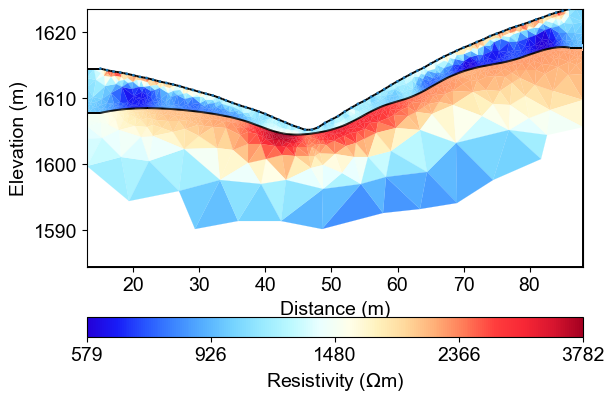

In [21]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18
fixed_cmap = BlueDarkRed18_18.mpl_colormap

res_cov = mgrConstrained.coverage()[mgrConstrained.paraDomain.cellMarkers()]>-1.2

mgrConstrained.showResult(xlabel="Distance (m)", ylabel="Elevation (m)",coverage = res_cov,cMap=fixed_cmap)

In [1]:
mesh_with_interface.save("results/Structure_WC/mesh_with_interface.bms")

NameError: name 'mesh_with_interface' is not defined

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x279201247d0>)

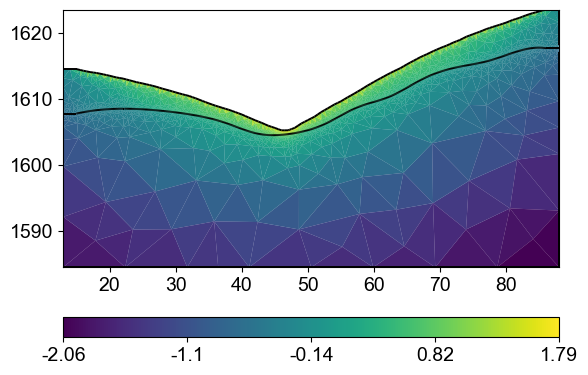

In [23]:
pg.show(mgrConstrained.paraDomain, mgrConstrained.coverage()[mgrConstrained.paraDomain.cellMarkers()])

In [24]:
mgrConstrained.paraDomain

Mesh: Nodes: 2352 Cells: 4501 Boundaries: 690

In [25]:
data_dir = "results/TL_measurements/appres"

# List of ERT data files testing monthly time-lapse inversion
ert_files = [
    "synthetic_data30.dat",
    "synthetic_data60.dat",
    "synthetic_data90.dat",
    "synthetic_data120.dat",
    "synthetic_data150.dat",
    "synthetic_data180.dat",
    "synthetic_data210.dat",
    "synthetic_data240.dat",
    "synthetic_data270.dat",
    "synthetic_data300.dat",
    "synthetic_data330.dat",
    "synthetic_data360.dat",
]

# ert_files = [
#     "synthetic_data30.dat",
#     "synthetic_data90.dat",
#     "synthetic_data150.dat",
#     "synthetic_data210.dat",
#     "synthetic_data270.dat",
#     "synthetic_data330.dat",
# ]


(<Axes: >, None)

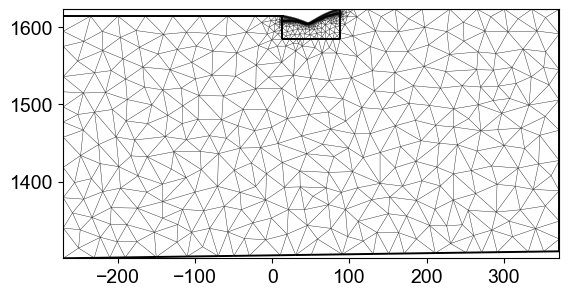

In [26]:
pg.show(mesh_with_interface)

In [27]:
# Full paths to data files
data_files = [os.path.join(data_dir, f) for f in ert_files]

# Measurement times (can be timestamps or any sequential numbers representing time)
measurement_times = [1, 2, 3, 4, 5, 6, 7 ,8, 9, 10, 11, 12]  # Adjust based on your actual acquisition times

# Create a mesh for the inversion (or load an existing one)
data = ert.load(data_files[0])
ert_manager = ert.ERTManager(data)
mesh = ert_manager.createMesh(data=data, quality=34)

# Set up inversion parameters
inversion_params = {
    "lambda_val": 50.0,              # Regularization parameter
    "alpha": 10.0,                   # Temporal regularization parameter
    "decay_rate": 0.0,               # Temporal decay rate
    "method": "cgls",                # Solver method ('cgls', 'lsqr', etc.)
    "model_constraints": (0.001, 1e4), # Min/max resistivity values (ohm-m)
    "max_iterations": 15,            # Maximum iterations
    "absoluteUError": 0.0,           # Absolute data error (V)
    "relativeError": 0.05,           # Relative data error (5%)
    "lambda_rate": 1.0,              # Lambda reduction rate
    "lambda_min": 1.0,               # Minimum lambda value
    "inversion_type": "L2"           # 'L1', 'L2', or 'L1L2'
}

# Create the time-lapse inversion object
inversion = TimeLapseERTInversion(
    data_files=data_files,
    measurement_times=measurement_times,
    mesh=mesh_with_interface,
    **inversion_params
)

# Run the inversion
print("Starting time-lapse inversion...")
result = inversion.run()
print("Inversion complete!")

10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 2 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.


Starting time-lapse inversion...


10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:06 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:07 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:07 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:07 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:07 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:07 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:07 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:07 - pyGIMLi - INFO - Found 3 regions.
10/05/25 - 12:03:07 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
10/05/25 - 12:03:07 - pyGIMLi - IN

-6.907755278982137 9.210340371976184
-------------------ERT Iteration: 0 ---------------------------


10/05/25 - 12:03:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:03:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/05/25 - 12:03:44 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 11000 Cells: 21572 Boundaries: 16392
10/05/25 - 12:04:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:04:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/05/25 - 12:04:07 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 11000 Cells: 21572 Boundaries: 16392
10/05/25 - 12:04:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:04:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
10/05/25 - 12:04:30 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 11000 Cells: 21572 Boundaries: 16392
10/05/25 - 12:04:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
10/05/25 - 12:04:55 - pyGIMLi - INFO - Creating refined mesh (H2) to solve fo

ERT chi2: 2345.570854628281
dPhi: 1.0
ERTphi_d: 23305592.0115866, ERTphi_m: 0.0, ERTphi_t: 0.0


UnboundLocalError: cannot access local variable 'Jr' where it is not associated with a value